In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import dask.dataframe as ddf
from rasterio.plot import show
import matplotlib.pyplot as plt

In [2]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## USDA CDL crop classification

In [3]:
USDA_cdl_class_df = pd.read_csv('../../Data_main\Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index(keys='Class')
USDA_cdl_class_df.head()

,Crop,min_wrq,avg_wrq,max_wrq
Class,,,,
1,Corn,600.0,680.0,760.0
2,Cotton,700.0,1000.0,1300.0
3,Rice,450.0,575.0,700.0
4,Sorghum,530.0,680.0,830.0
5,Soybeans,450.0,600.0,750.0


In [4]:
# making the df to a dictionary
usda_cdl_dict = USDA_cdl_class_df.to_dict()
usda_cdl_dict = usda_cdl_dict['Crop']
usda_cdl_dict

{1: 'Corn',
 2: 'Cotton',
 3: 'Rice',
 4: 'Sorghum',
 5: 'Soybeans',
 6: 'Sunflower',
 10: 'Peanuts',
 11: 'Tobacco',
 12: 'Sweet Corn',
 13: 'Pop or Orn Corn',
 14: 'Mint',
 21: 'Barley',
 22: 'Durum Wheat',
 23: 'Spring Wheat',
 24: 'Winter Wheat',
 25: 'Other Small Grains',
 26: 'Dbl Crop WinWht/Soybeans',
 27: 'Rye',
 28: 'Oats',
 29: 'Millet',
 30: 'Speltz',
 31: 'Canola',
 32: 'Flaxseed',
 33: 'Safflower',
 34: 'Rape Seed',
 35: 'Mustard',
 36: 'Alfalfa',
 37: 'Other Hay/Non Alfalfa',
 38: 'Camelina',
 39: 'Buckwheat',
 41: 'Sugarbeets',
 42: 'Dry Beans',
 43: 'Potatoes',
 44: 'Other Crops',
 45: 'Sugarcane',
 46: 'Sweet Potatoes',
 47: 'Misc Vegs & Fruits',
 48: 'Watermelons',
 49: 'Onions',
 50: 'Cucumbers',
 51: 'Chick Peas',
 52: 'Lentils',
 53: 'Peas',
 54: 'Tomatoes',
 55: 'Caneberries',
 56: 'Hops',
 57: 'Herbs',
 58: 'Clover/Wildflowers',
 59: 'Sod/Grass Seed',
 60: 'Switchgrass',
 61: 'Fallow/Idle Cropland',
 63: 'Forest',
 64: 'Shrubland',
 65: 'Barren',
 66: 'Cherries'

------------------------

Looks like southwest OK and TX has higher minimun average monthly temperature than our ROI in NE and KS. Also, the eastern part of KS, OK, and TX have higher tree cover, leading to higher total ET.

Minimum temperature and total ET seem to have a linear trend. High min temperature might be a reason of high ET even from rainfed regions in OK and TX.

-------------------------

# Is ET more correlated to precipitation or Irrigation?

### ET vs Precip : Central valley, CA (Irrigated)

In [5]:
CA_monthly_data_dict = {2016: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2016.parquet', 
                        2017: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2017.parquet', 
                        # 2018: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2018.parquet', 
                        # 2019: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2019.parquet', 
                        # 2020: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2020.parquet'
                       }

for count, path in enumerate(CA_monthly_data_dict.keys()):
    if count == 0:
        monthly_ddf = ddf.read_parquet(CA_monthly_data_dict[path])
        CA_monthly_ddf = monthly_ddf
    else:
        monthly_ddf =  ddf.read_parquet(CA_monthly_data_dict[path])
        CA_monthly_ddf = ddf.concat([CA_monthly_ddf, monthly_ddf], axis=0)

CA_monthly_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
0,124.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
1,126.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
2,118.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
3,123.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
4,123.0,2016,4,47.359001,126.480003,176.0,0.0,1.0


In [6]:
CA_irrigated_ddf = CA_monthly_ddf[(CA_monthly_ddf['Irrigated'] == 1) & (CA_monthly_ddf['PRISM_ppt'] <= 200)]
CA_irrigated_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
42,105.0,2016,4,47.359001,126.480003,24.0,1.0,0.0
43,105.0,2016,4,47.359001,126.480003,208.0,1.0,0.0
44,96.0,2016,4,47.359001,126.480003,176.0,1.0,0.0
59,89.0,2016,4,47.359001,126.480003,208.0,1.0,0.0
60,91.0,2016,4,47.359001,126.480003,208.0,1.0,0.0


In [7]:
x = CA_irrigated_ddf[['PRISM_ppt']].compute()
y = CA_irrigated_ddf[['OpenET']].compute()

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[-0.91295093]], dtype=float32)

Coefficient of determination: 0.17


(0.0, 260.0)

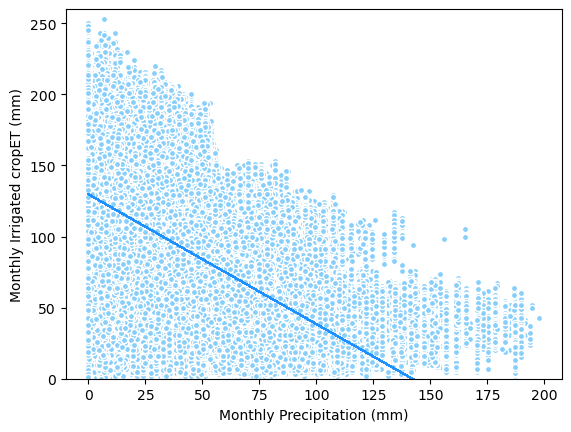

In [8]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='lightskyblue', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='dodgerblue', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Irrigated cropET (mm)')
plt.ylim(0, 260)

In Central Valley, irrigated croplands' ET has negative correlation with precipitation. That means __something else (irrigation)__ is the controlling factor of ET.

### ET vs Precip : Central valley, CA (Rainfed)

In [9]:
CA_rainfed_ddf = CA_monthly_ddf[(CA_monthly_ddf['Rainfed'] == 1) & (CA_monthly_ddf['PRISM_ppt'] <= 200)]
CA_rainfed_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
0,124.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
1,126.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
2,118.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
3,123.0,2016,4,47.359001,126.480003,176.0,0.0,1.0
4,123.0,2016,4,47.359001,126.480003,176.0,0.0,1.0


In [10]:
x = CA_rainfed_ddf[['PRISM_ppt']].compute()
y = CA_rainfed_ddf[['OpenET']].compute()

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.14030814]], dtype=float32)

Coefficient of determination: 0.02


(0.0, 260.0)

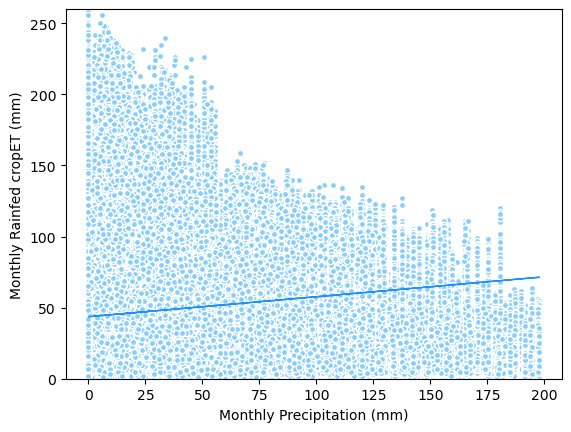

In [11]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='lightskyblue', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='dodgerblue', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Rainfed cropET (mm)')
plt.ylim(0, 260)

In rainfed pasture lands buffer around Central Valley, monthly ET reponses positively to monthly precipitation. But the higher ET than precipitation (left side above the regression line) of the plot suggest, there might be high ET at months when there is no/minimal precip. We recommend using the term __"effective precipitation"__ (remainder precip after deep percolation and surface runoff, and water from soil storage supplied by precip from previous months/year) in this case.

# ET vs Precip : GMD4, KS (Irrigated)

In [12]:
KS_monthly_data_dict = {2016: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2016.parquet', 
                        2017: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2017.parquet', 
                        # 2018: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2018.parquet', 
                        # 2019: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2019.parquet', 
                        # 2020: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2020.parquet'
                       }

for count, path in enumerate(KS_monthly_data_dict.keys()):
    if count == 0:
        monthly_ddf = ddf.read_parquet(KS_monthly_data_dict[path])
        KS_monthly_ddf = monthly_ddf
    else:
        monthly_ddf =  ddf.read_parquet(KS_monthly_data_dict[path])
        KS_monthly_ddf = ddf.concat([KS_monthly_ddf, monthly_ddf], axis=0)
        
KS_monthly_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
0,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
1,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
2,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
3,36.0,2016,4,153.007004,99.875,1.0,0.0,1.0
4,36.0,2016,4,153.007004,99.875,1.0,0.0,1.0


In [13]:
KS_irrigated_ddf = KS_monthly_ddf[KS_monthly_ddf['Irrigated'] == 1]
KS_irrigated_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
58,83.0,2016,4,153.007004,100.214996,24.0,1.0,0.0
63,84.0,2016,4,153.007004,100.214996,24.0,1.0,0.0
64,84.0,2016,4,153.007004,100.214996,24.0,1.0,0.0
67,97.0,2016,4,153.007004,100.214996,24.0,1.0,0.0
68,97.0,2016,4,153.007004,100.214996,24.0,1.0,0.0


In [14]:
x = KS_irrigated_ddf[['PRISM_ppt']].compute()
y = KS_irrigated_ddf[['OpenET']].compute()

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.03282104]], dtype=float32)

Coefficient of determination: 0.00


Text(0, 0.5, 'Monthly Irrigated cropET (mm)')

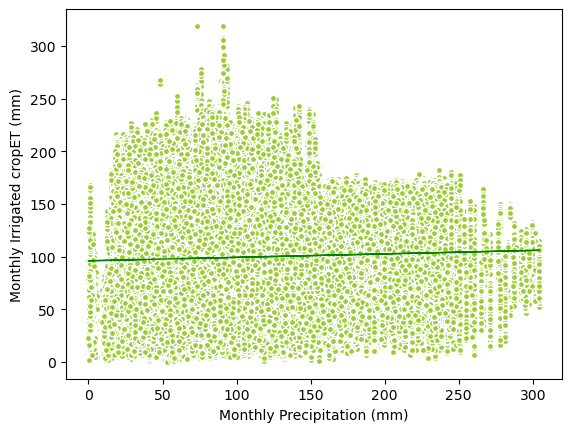

In [15]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Irrigated cropET (mm)')

# ET vs Precip : GMD4, KS (Rainfed)

In [16]:
KS_rainfed_ddf = KS_monthly_ddf[KS_monthly_ddf['Rainfed'] == 1]
KS_rainfed_ddf.head()

,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed
0,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
1,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
2,35.0,2016,4,153.007004,99.875,1.0,0.0,1.0
3,36.0,2016,4,153.007004,99.875,1.0,0.0,1.0
4,36.0,2016,4,153.007004,99.875,1.0,0.0,1.0


In [17]:
x = KS_rainfed_ddf[['PRISM_ppt']].compute()
y = KS_rainfed_ddf[['OpenET']].compute()

#train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, shuffle=True)
x_train, x_test, y_train, y_test = x_train.values, x_test.values, y_train.values, y_test.values

# linear model
lm = LinearRegression()
lm_trained = lm.fit(x_train, y_train)
lm_trained.coef_

array([[0.13731147]], dtype=float32)

Coefficient of determination: 0.03


Text(0, 0.5, 'Monthly Rainfed cropET (mm)')

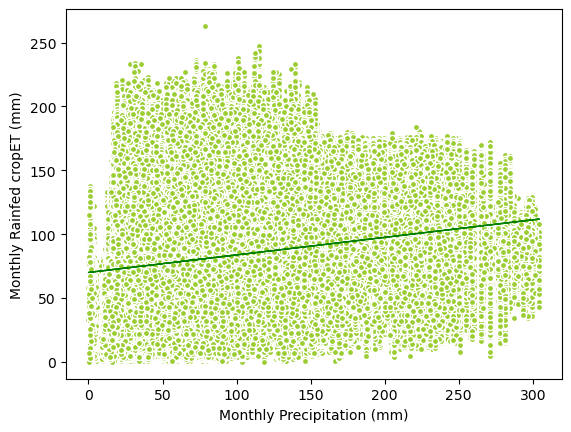

In [18]:
# R2 
y_test_pred = lm_trained.predict(x_test)
r2 = r2_score(y_test, y_test_pred)

# plot performance
print("Coefficient of determination: %.2f" % r2)
plt.scatter(x_test, y_test, facecolor='yellowgreen', edgecolor='white', s=20)
plt.plot(x_test, y_test_pred, color='green', linewidth=1)
plt.xlabel('Monthly Precipitation (mm)')
plt.ylabel('Monthly Rainfed cropET (mm)')

Monthly ET responses similary to monthly precipitation in Kansas in both Irrigated and Rainfed croplands. This means __irrigation has minimal to no effect on ET__. To prove this hypothesis, we compare annual ET with annual irrigation and annual pumping.

## Annual ET vs Irrigation : __GMD4__, KS (Irrigated) (2km scale)

In [19]:
gmd4_df = pd.read_csv('../../Data_main/Data_drivers_of_ET/CSVs/KS_GW_GMD4_updated.csv')
gmd4_df = gmd4_df[gmd4_df.WU_mm < 2500]
gmd4_df.columns

Index(['Acres', 'CDL', 'GPM_PPT', 'OBJECTID', 'PDIV_ID', 'PRISM_PPT',
       'PRISM_TMAX', 'SSEBop', 'TC_PPT', 'TC_RO', 'TC_SM', 'TC_TMAX', 'WU_AF',
       'WU_mm', 'Year', 'gmd', 'lat_nad83', 'long_nad83', 'FREQUENCY', 'Crop',
       'Irrigated_cropET', 'OpenET'],
      dtype='object')

In [20]:
# Irrigation vs SSEBop Total ET linear model
x_1 = gmd4_df[['WU_mm']]
y_1 = gmd4_df[['OpenET']]

# train-test split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size=0.3, random_state=0, shuffle=True)
x_train_1, x_test_1, y_train_1, y_test_1 = x_train_1.values, x_test_1.values, y_train_1.values, y_test_1.values

# linear model
lm_1 = LinearRegression()
lm_trained_1 = lm_1.fit(x_train_1, y_train_1)


# Irrigation vs Irrigated CropET linear model
x_2 = gmd4_df[['WU_mm']]
y_2 = gmd4_df[['Irrigated_cropET']]

# train-test split
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.3, random_state=0, shuffle=True)
x_train_2, x_test_2, y_train_2, y_test_2 = x_train_2.values, x_test_2.values, y_train_2.values, y_test_2.values

# linear model
lm_2 = LinearRegression()
lm_trained_2 = lm_2.fit(x_train_2, y_train_2)

Looks like both annual total ET is negatively correlated to Irrigation, but  has a positive correlation with Irrigation. 

### Annual ET vs Precipitation : __GMD4__, KS (Irrigated)

In [21]:
# Precipitation vs total OpenET linear model
x_3 = gmd4_df[['PRISM_PPT']]
y_3 = gmd4_df[['OpenET']]

# train-test split
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, test_size=0.3, random_state=0, shuffle=True)
x_train_3, x_test_3, y_train_3, y_test_3 = x_train_3.values, x_test_3.values, y_train_3.values, y_test_3.values

# linear model
lm_3 = LinearRegression()
lm_trained_3 = lm_3.fit(x_train_3, y_train_3)


# Precipitation vs Irrigated CropET linear model
x_4 = gmd4_df[['PRISM_PPT']]
y_4 = gmd4_df[['Irrigated_cropET']]

# train-test split
x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(x_4, y_4, test_size=0.3, random_state=0, shuffle=True)
x_train_4, x_test_4, y_train_24, y_test_4 = x_train_4.values, x_test_4.values, y_train_4.values, y_test_4.values

# linear model
lm_4 = LinearRegression()
lm_trained_4 = lm_4.fit(x_train_4, y_train_4)

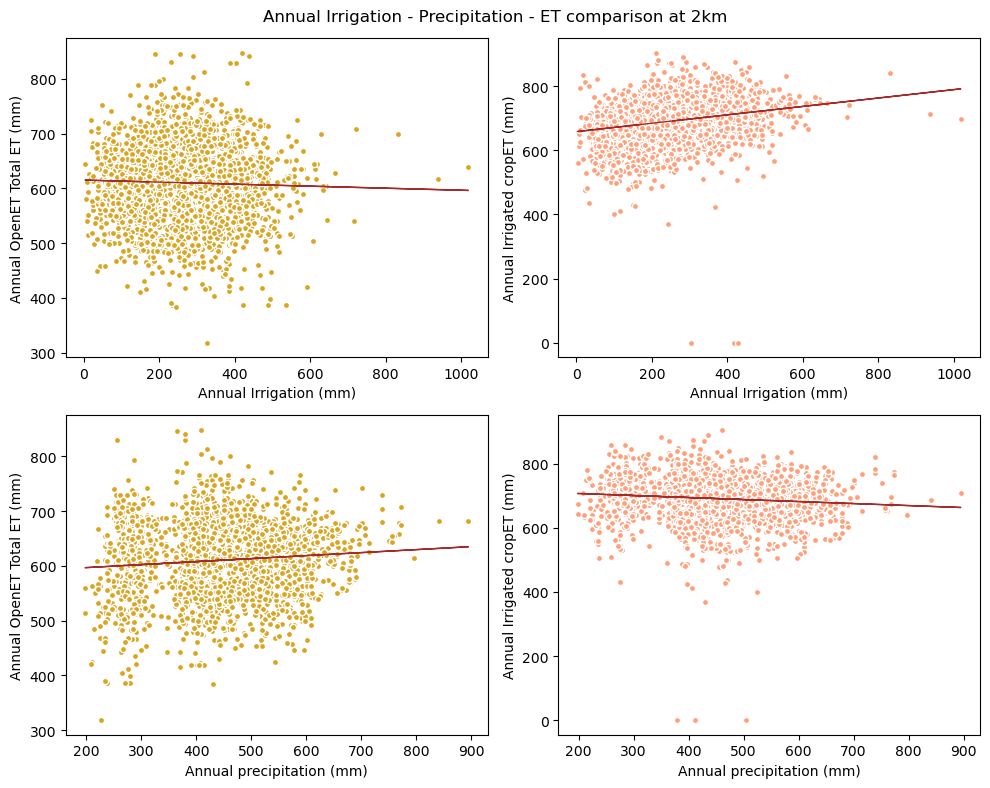

In [22]:
# prediction total OpenET vs irrigation model
y_test_pred_1 = lm_trained_1.predict(x_test_1)

# prediction irrigated cropET vs irrigation model
y_test_pred_2 = lm_trained_2.predict(x_test_2)

# prediction OpenET vs precipitation model
y_test_pred_3 = lm_trained_3.predict(x_test_3)

# prediction irrigated cropET vs precipitation model
y_test_pred_4 = lm_trained_4.predict(x_test_4)

# plot
fig, ax = plt.subplots(2, 2, figsize=(10,8))
ax[0, 0].scatter(x_test_1, y_test_1, facecolor='goldenrod', edgecolor='white', s=20)
ax[0, 0].plot(x_test_1, y_test_pred_1, color="brown", linewidth=1)
ax[0, 0].set_xlabel('Annual Irrigation (mm)')
ax[0, 0].set_ylabel('Annual OpenET Total ET (mm)')

ax[0, 1].scatter(x_test_2, y_test_2, facecolor='lightsalmon', edgecolor='white', s=20)
ax[0, 1].plot(x_test_2, y_test_pred_2, color="brown", linewidth=1)
ax[0, 1].set_xlabel('Annual Irrigation (mm)')
ax[0, 1].set_ylabel('Annual Irrigated cropET (mm)')

ax[1, 0].scatter(x_test_3, y_test_3, facecolor='goldenrod', edgecolor='white', s=20)
ax[1, 0].plot(x_test_3, y_test_pred_3, color="brown", linewidth=1)
ax[1, 0].set_xlabel('Annual precipitation (mm)')
ax[1, 0].set_ylabel('Annual OpenET Total ET (mm)')

ax[1, 1].scatter(x_test_4, y_test_4, facecolor='lightsalmon', edgecolor='white', s=20)
ax[1, 1].plot(x_test_4, y_test_pred_4, color="brown", linewidth=1)
ax[1, 1].set_xlabel('Annual precipitation (mm)')
ax[1, 1].set_ylabel('Annual Irrigated cropET (mm)')

fig.suptitle('Annual Irrigation - Precipitation - ET comparison at 2km')
plt.tight_layout()

Looks like __in Kansas GMD4__, Annual total ET is driven by precipitation. But in irrigated croplnads, irrigated cropET is driven by irrigation.

## Precipitation vs Irrigation in __GMD4__ 

In [23]:
# Irrigation vs SSEBop Total ET linear model
x_5 = gmd4_df[['PRISM_PPT']]
y_5 = gmd4_df[['WU_mm']]

# train-test split
x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(x_5, y_5, test_size=0.3, random_state=0, shuffle=True)
x_train_5, x_test_5, y_train_5, y_test_5 = x_train_5.values, x_test_5.values, y_train_5.values, y_test_5.values

# linear model
lm_5 = LinearRegression()
lm_trained_5 = lm_5.fit(x_train_5, y_train_5)

Text(0, 0.5, 'Annual Irrigation (mm)')

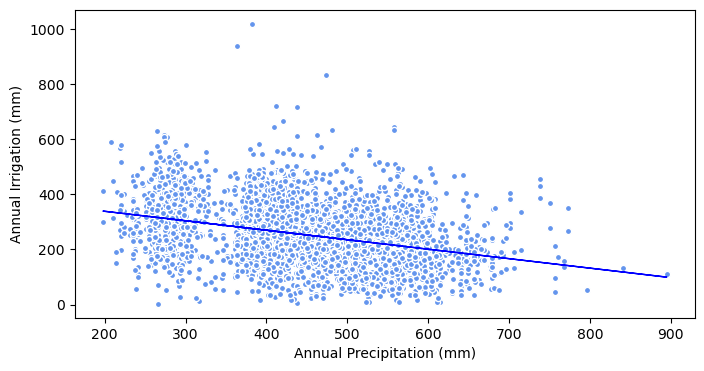

In [24]:
# prediction precipitation vs irrigation model
y_test_pred_5 = lm_trained_5.predict(x_test_5)

# plot
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(x_test_5, y_test_5, facecolor='cornflowerblue', edgecolor='white', s=20)
ax.plot(x_test_5, y_test_pred_5, color="blue", linewidth=1)
ax.set_xlabel('Annual Precipitation (mm)')
ax.set_ylabel('Annual Irrigation (mm)')

__As precipitation increases, Irrigation decreases in GMD4.__

# How ET varies with crop type

## GMD4 KS: irrigated vs rainfed

In [25]:
KS_monthly_data_dict = {2016: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2016.parquet', 
                        2017: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2017.parquet', 
                        # 2018: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2018.parquet', 
                        # 2019: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2019.parquet', 
                        # 2020: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_monthly_2020.parquet'
                       }

for count, path in enumerate(KS_monthly_data_dict.keys()):
    if count == 0:
        monthly_ddf = ddf.read_parquet(KS_monthly_data_dict[path])
        KS_monthly_ddf = monthly_ddf
    else:
        monthly_ddf =  ddf.read_parquet(KS_monthly_data_dict[path])
        KS_monthly_ddf = ddf.concat([KS_monthly_ddf, monthly_ddf], axis=0)
        
KS_monthly_df = KS_monthly_ddf.compute()
type(KS_monthly_df)

pandas.core.frame.DataFrame

In [26]:
# filtering irrigated vs rainfed dask dataframe
KS_irrigated_df = KS_monthly_df[KS_monthly_df['Irrigated'] == 1]
KS_rainfed_df = KS_monthly_df[KS_monthly_df['Rainfed'] == 1]

type(KS_irrigated_df)

pandas.core.frame.DataFrame

In [27]:
# Irrigated
KS_irrigated_df.loc[:, 'Crop'] = KS_irrigated_df['USDA_CDL'].map(usda_cdl_dict)
KS_irrigated_df = KS_irrigated_df[KS_irrigated_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans'])]
KS_irrigated_df = KS_irrigated_df[KS_irrigated_df['month'].isin([6, 7, 8, 9])]

# Rainfed
KS_rainfed_df.loc[:, 'Crop'] = KS_rainfed_df['USDA_CDL'].map(usda_cdl_dict)
KS_rainfed_df = KS_rainfed_df[KS_rainfed_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]
KS_rainfed_df = KS_rainfed_df[KS_rainfed_df['month'].isin([6, 7, 8, 9])]

KS_irrigated_df.head()

C:\Users\fahim\AppData\Local\Temp\ipykernel_880\350671656.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KS_irrigated_df.loc[:, 'Crop'] = KS_irrigated_df['USDA_CDL'].map(usda_cdl_dict)
C:\Users\fahim\AppData\Local\Temp\ipykernel_880\350671656.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KS_rainfed_df.loc[:, 'Crop'] = KS_rainfed_df['USDA_CDL'].map(usda_cdl_dict)


,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed,Crop
12532068,143.0,2016,6,81.111,180.880005,24.0,1.0,0.0,Winter Wheat
12532073,164.0,2016,6,81.111,180.880005,24.0,1.0,0.0,Winter Wheat
12532074,164.0,2016,6,81.111,180.880005,24.0,1.0,0.0,Winter Wheat
12532077,178.0,2016,6,81.111,180.880005,24.0,1.0,0.0,Winter Wheat
12532078,178.0,2016,6,81.111,180.880005,24.0,1.0,0.0,Winter Wheat


(0.0, 300.0)

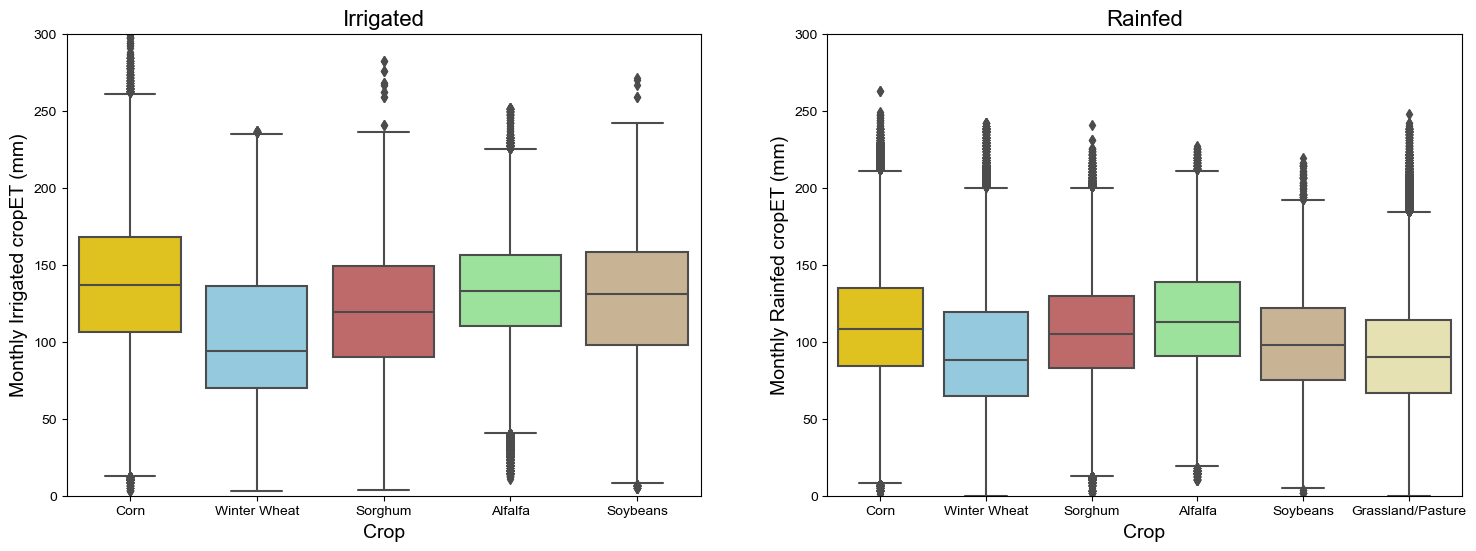

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Alfalfa': 'lightgreen', 
                          'Soybeans': 'tan', 'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr = ['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans']
category_order_rain = ['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Grassland/Pasture']

# irrigated
sns.boxplot(x=KS_irrigated_df['Crop'], y=KS_irrigated_df['OpenET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=KS_rainfed_df['Crop'], y=KS_rainfed_df['OpenET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('Rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

Slightly higher growing season monthly ET in irrigated crops than rainfed crops in __GMD4__ Kansas.

__In the rainfed fields, the ET is consistently low. Possibly we can use this to calculate a ratio between rainfed cropET (effective precip) and Irrigated cropET for each crop. Though the ratios will be extracted from 30m scale, they can be used to extract the effective precipitation information from irrigated cropET data at 2km scale.__

`Think about bringing the plots together side-by-side.`

### Estiamting the ratio between Rainfed cropET (Effective Precip) vs Irrigated cropET

In [29]:
rainfed_cropET_df = KS_rainfed_df.groupby(by='Crop', axis=0)['OpenET'].median()
rainfed_cropET_df = rainfed_cropET_df.reset_index()
rainfed_cropET_df = rainfed_cropET_df.rename(columns={'OpenET': 'Rainfed cropET (mm)'})

,Crop,Rainfed cropET (mm)
0,Alfalfa,113.0
1,Corn,108.0
2,Grassland/Pasture,90.0
3,Sorghum,105.0
4,Soybeans,98.0
5,Winter Wheat,88.0


In [30]:
irrigated_cropET_df = KS_irrigated_df.groupby(by='Crop', axis=0)['OpenET'].median()
irrigated_cropET_df = irrigated_cropET_df.reset_index()
irrigated_cropET_df = irrigated_cropET_df.rename(columns={'OpenET': 'Irrigated cropET (mm)'})

,Crop,Irrigated cropET (mm)
0,Alfalfa,133.0
1,Corn,137.0
2,Sorghum,119.0
3,Soybeans,131.0
4,Winter Wheat,94.0


In [31]:
effective_precip_ratio_df = rainfed_cropET_df.merge(irrigated_cropET_df, on=['Crop'])
effective_precip_ratio_df['ratio_effec_precip'] = effective_precip_ratio_df['Rainfed cropET (mm)'] / effective_precip_ratio_df['Irrigated cropET (mm)']
effective_precip_ratio_df

,Crop,Rainfed cropET (mm),Irrigated cropET (mm),ratio_effec_precip
0,Alfalfa,113.0,133.0,0.849624
1,Corn,108.0,137.0,0.788321
2,Sorghum,105.0,119.0,0.882353
3,Soybeans,98.0,131.0,0.748092
4,Winter Wheat,88.0,94.0,0.936170


## Central Valley CA: irrigated vs rainfed

In [32]:
CA_monthly_data_dict = {2016: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2016.parquet', 
                        2017: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2017.parquet', 
                        # 2018: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2018.parquet', 
                        # 2019: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2019.parquet', 
                        # 2020: '../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_monthly_2020.parquet'
                       }

for count, path in enumerate(CA_monthly_data_dict.keys()):
    if count == 0:
        monthly_ddf = ddf.read_parquet(CA_monthly_data_dict[path])
        CA_monthly_ddf = monthly_ddf
    else:
        monthly_ddf =  ddf.read_parquet(CA_monthly_data_dict[path])
        CA_monthly_ddf = ddf.concat([CA_monthly_ddf, monthly_ddf], axis=0)

CA_monthly_df = CA_monthly_ddf.compute()
type(CA_monthly_df)

pandas.core.frame.DataFrame

In [33]:
# filtering irrigated vs rainfed dask dataframe
CA_irrigated_df = CA_monthly_df[CA_monthly_df['Irrigated'] == 1]
CA_rainfed_df = CA_monthly_df[CA_monthly_df['Rainfed'] == 1]

type(CA_irrigated_df)

pandas.core.frame.DataFrame

In [34]:
# Irrigated
CA_irrigated_df.loc[:, 'Crop'] = CA_irrigated_df['USDA_CDL'].map(usda_cdl_dict)
CA_irrigated_df = CA_irrigated_df[CA_irrigated_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans'])]
CA_irrigated_df = CA_irrigated_df[CA_irrigated_df['month'].isin([6, 7, 8, 9])]

# Rainfed
CA_rainfed_df.loc[:, 'Crop'] = CA_rainfed_df['USDA_CDL'].map(usda_cdl_dict)
CA_ainfed_df = CA_rainfed_df[CA_rainfed_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans', 'Grassland/Pasture'])]
CA_rainfed_df = CA_rainfed_df[CA_rainfed_df['month'].isin([6, 7, 8, 9])]

print(CA_irrigated_df.Crop.unique())
CA_irrigated_df.head()

C:\Users\fahim\AppData\Local\Temp\ipykernel_880\3661877763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_irrigated_df.loc[:, 'Crop'] = CA_irrigated_df['USDA_CDL'].map(usda_cdl_dict)
C:\Users\fahim\AppData\Local\Temp\ipykernel_880\3661877763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CA_rainfed_df.loc[:, 'Crop'] = CA_rainfed_df['USDA_CDL'].map(usda_cdl_dict)


['Winter Wheat' 'Alfalfa' 'Corn' 'Sorghum']


,OpenET,year,month,PRISM_ppt,GridMET_RET,USDA_CDL,Irrigated,Rainfed,Crop
9748732,44.0,2016,6,55.546001,190.059998,24.0,1.0,0.0,Winter Wheat
9748772,34.0,2016,6,55.546001,190.059998,24.0,1.0,0.0,Winter Wheat
9748773,34.0,2016,6,55.546001,190.059998,24.0,1.0,0.0,Winter Wheat
9748788,37.0,2016,6,55.546001,190.059998,24.0,1.0,0.0,Winter Wheat
9748920,46.0,2016,6,55.546001,190.059998,24.0,1.0,0.0,Winter Wheat


(0.0, 300.0)

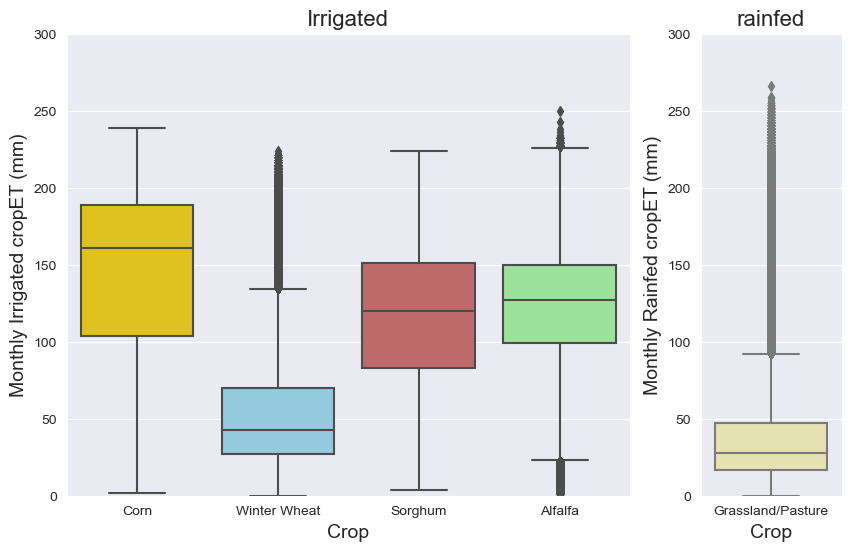

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [4, 1]})
sns.set_style("darkgrid")

# setting similar color palette for similar crops 
category_colors = {'Corn': 'gold', 'Rice': 'thistle', 'Tomatoes': 'tomato', 'Alfalfa': 'lightgreen',  
                   'Winter Wheat': 'skyblue', 'Sorghum': 'indianred', 'Almonds': 'perU', 
                   'Grapes': 'slateblue', 'Walnuts': 'rosybrown',  'Grassland/Pasture': 'palegoldenrod'}

# category order
category_order_irr= ['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa']
category_order_rain = ['Grassland/Pasture']

# irrigated
sns.boxplot(x=CA_irrigated_df['Crop'], y=CA_irrigated_df['OpenET'], ax=ax[0], palette=category_colors, order=category_order_irr)
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('Monthly Irrigated cropET (mm)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].set_title('Irrigated', fontsize=16)
ax[0].set_ylim(0, 300)

# rainfed
sns.boxplot(x=CA_rainfed_df['Crop'], y=CA_rainfed_df['OpenET'], ax=ax[1], palette=category_colors, order=category_order_rain)
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('Monthly Rainfed cropET (mm)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].set_title('rainfed', fontsize=16)
ax[1].set_ylim(0, 300)

A large difference between cropET in irrigated abnd rainfed crops. This shows the contribution of irrigation in Central valley. High outliers in Winter Wheat and Alfalfa might be due to the fact that this analysis was done using some part of the Central Valley. With more areas included, the outliers detected won't be detected as outliers.

`Think about including more area with more types of crops as Central Valley is has very diverse crop type.`

# How much gap does irrigation have to fill?

### GMD4 KS

In [36]:
# Converting crop class information to a dictionary
USDA_cdl_class_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Class')
usda_cdl_dict_crop = USDA_cdl_class_df.to_dict()['Crop']
# usda_cdl_dict_crop

In [37]:
# Irrigated (GMD4)
KS_annual_df = pd.read_parquet('../../Data_main/Data_Drivers_of_ET/CSVs/30m/KS_annual.parquet')
KS_annual_df = KS_annual_df[KS_annual_df['Irrigated']==1]
KS_annual_df['Crop'] = KS_annual_df['USDA_CDL'].map(usda_cdl_dict_crop)
KS_annual_df = KS_annual_df[KS_annual_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa', 'Soybeans'])] 
print(KS_annual_df.head())

# Groupby Operation
summary_df_KS = KS_annual_df.groupby(by='Crop', axis=0).aggregate({'PRISM_ppt': ['min', 'median', 'max'],
                                                                   'OpenET': ['min', 'median', 'max'],
                                                                   'GridMET_RET': ['min', 'median', 'max']})
summary_df_KS = summary_df_KS.reset_index()
summary_df_KS

    OpenET   PRISM_ppt  GridMET_RET  USDA_CDL  Irrigated  Rainfed  \
58   553.0  681.499023   968.320007      24.0        1.0      0.0   
63   639.0  681.499023   968.320007      24.0        1.0      0.0   
64   639.0  681.499023   968.320007      24.0        1.0      0.0   
67   668.0  681.499023   968.320007      24.0        1.0      0.0   
68   668.0  681.499023   968.320007      24.0        1.0      0.0   

            Crop  
58  Winter Wheat  
63  Winter Wheat  
64  Winter Wheat  
67  Winter Wheat  
68  Winter Wheat  


Crop PRISM_ppt                          OpenET                 \
                      min      median          max    min median     max   
0       Alfalfa       0.0  635.637939  1194.500977  143.0  808.0  1215.0   
1          Corn       0.0  623.703979  1207.558960  158.0  707.0  1153.0   
2       Sorghum       0.0  619.240967  1207.558960  212.0  633.0  1104.0   
3      Soybeans       0.0  670.443970  1192.744995  269.0  655.0  1003.0   
4  Winter Wheat       0.0  578.370972  1207.558960  140.0  681.0  1171.0   

  GridMET_RET                           
          min      median          max  
0         0.0  971.039978  1091.400024  
1         0.0  972.484985  1089.104980  
2         0.0  972.570007  1089.104980  
3         0.0  973.335022  1078.904907  
4         0.0  973.929993  1089.190063

In [38]:
# Converting crop class, min/ mean/ max seasonal water requirement information to a dictionary
USDA_cdl_class_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
print(USDA_cdl_class_df.columns)
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Crop')
usda_cdl_dict = USDA_cdl_class_df.to_dict()
# usda_cdl_dict

Index(['Class', 'Crop', 'min_wrq', 'avg_wrq', 'max_wrq'], dtype='object')


In [39]:
# Adding crop water requirement columns from USDA CDL dataframe
summary_df_KS['min_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['min_wrq'])
summary_df_KS['mean_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['avg_wrq'])
summary_df_KS['max_season_wrq'] = summary_df_KS['Crop'].map(usda_cdl_dict['max_wrq'])
summary_df_KS

Crop PRISM_ppt                          OpenET                 \
                      min      median          max    min median     max   
0       Alfalfa       0.0  635.637939  1194.500977  143.0  808.0  1215.0   
1          Corn       0.0  623.703979  1207.558960  158.0  707.0  1153.0   
2       Sorghum       0.0  619.240967  1207.558960  212.0  633.0  1104.0   
3      Soybeans       0.0  670.443970  1192.744995  269.0  655.0  1003.0   
4  Winter Wheat       0.0  578.370972  1207.558960  140.0  681.0  1171.0   

  GridMET_RET                          min_season_wrq mean_season_wrq  \
          min      median          max                                  
0         0.0  971.039978  1091.400024          500.0           825.0   
1         0.0  972.484985  1089.104980          600.0           680.0   
2         0.0  972.570007  1089.104980          530.0           680.0   
3         0.0  973.335022  1078.904907          450.0           600.0   
4         0.0  973.929993  1089.190063          400.0           450.0   

  max_season_wrq  
                  
0         1150.0  
1          760.0  
2          830.0  
3          750.0  
4          500.0

### Central Valley CA

In [40]:
# Converting crop class information to a dictionary
USDA_cdl_class_df = pd.read_csv('../../Data_main/Data_Drivers_of_ET/CSVs/USDA_cdl_classification.csv')
USDA_cdl_class_df = USDA_cdl_class_df.set_index('Class')
usda_cdl_dict_crop = USDA_cdl_class_df.to_dict()['Crop']
# usda_cdl_dict_crop

In [41]:
# Irrigated (CV)
CA_annual_df = pd.read_parquet('../../Data_main/Data_Drivers_of_ET/CSVs/30m/CA_annual.parquet')
CA_annual_df = CA_annual_df[CA_annual_df['Irrigated']==1]
CA_annual_df['Crop'] = CA_annual_df['USDA_CDL'].map(usda_cdl_dict_crop)
CA_annual_df = CA_annual_df[CA_annual_df['Crop'].isin(['Corn', 'Winter Wheat', 'Sorghum', 'Alfalfa'])]   # ('Corn', 'Rice', 'Alfalfa', 'Tomatoes', 'Grapes', 'Almonds', 'Walnuts')
print(CA_annual_df.head())

# Groupby Operation
summary_df_CA = CA_annual_df.groupby(by='Crop', axis=0).aggregate({'PRISM_ppt': ['min', 'median', 'max'],
                                                                   'OpenET': ['min', 'median', 'max'],
                                                                   'GridMET_RET': ['min', 'median', 'max']})
summary_df_CA = summary_df_CA.reset_index()
summary_df_CA

     OpenET  PRISM_ppt  GridMET_RET  USDA_CDL  Irrigated  Rainfed  \
42    254.0  1440.5271  1079.415039      24.0        1.0      0.0   
82    218.0  1440.5271  1079.415039      24.0        1.0      0.0   
83    218.0  1440.5271  1079.415039      24.0        1.0      0.0   
98    217.0  1440.5271  1079.415039      24.0        1.0      0.0   
230   247.0  1440.5271  1079.415039      24.0        1.0      0.0   

             Crop  
42   Winter Wheat  
82   Winter Wheat  
83   Winter Wheat  
98   Winter Wheat  
230  Winter Wheat  


Crop PRISM_ppt                          OpenET                 \
                      min      median          max    min median     max   
0       Alfalfa       0.0  600.304016  1457.365967   38.0  822.0  1318.0   
1          Corn       0.0  565.361938  1170.396973  103.0  778.0  1324.0   
2       Sorghum       0.0  566.856018   945.077026  115.0  656.0  1219.0   
3  Winter Wheat       0.0  583.163025  1440.527100   25.0  473.0  1256.0   

  GridMET_RET                            
          min       median          max  
0         0.0  1074.060059  1351.415039  
1         0.0  1073.890015  1351.415039  
2         0.0  1042.695068  1351.415039  
3         0.0  1061.054932  1351.415039

In [42]:
# Adding crop water requirement columns from USDA CDL dataframe
summary_df_CA['min_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['min_wrq'])
summary_df_CA['mean_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['avg_wrq'])
summary_df_CA['max_season_wrq'] = summary_df_CA['Crop'].map(usda_cdl_dict['max_wrq'])
summary_df_CA

Crop PRISM_ppt                          OpenET                 \
                      min      median          max    min median     max   
0       Alfalfa       0.0  600.304016  1457.365967   38.0  822.0  1318.0   
1          Corn       0.0  565.361938  1170.396973  103.0  778.0  1324.0   
2       Sorghum       0.0  566.856018   945.077026  115.0  656.0  1219.0   
3  Winter Wheat       0.0  583.163025  1440.527100   25.0  473.0  1256.0   

  GridMET_RET                           min_season_wrq mean_season_wrq  \
          min       median          max                                  
0         0.0  1074.060059  1351.415039          500.0           825.0   
1         0.0  1073.890015  1351.415039          600.0           680.0   
2         0.0  1042.695068  1351.415039          530.0           680.0   
3         0.0  1061.054932  1351.415039          400.0           450.0   

  max_season_wrq  
                  
0         1150.0  
1          760.0  
2          830.0  
3          500.0

### Plotting

Text(0.5, 1.0, 'Central Valley, CA')

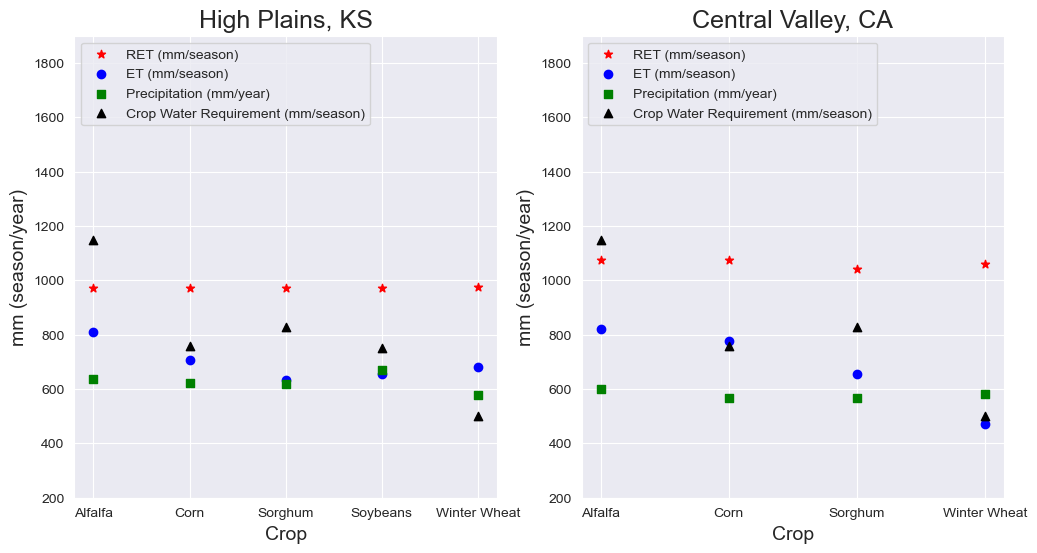

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("darkgrid")

# plotting KS
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['GridMET_RET']['median'], marker='*', color='r')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['OpenET']['median'], marker='o', color='b')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['PRISM_ppt']['median'], marker='s', color='g')
ax[0].scatter(summary_df_KS['Crop'], summary_df_KS['max_season_wrq'], marker="^", color='black')
ax[0].set_xlabel('Crop', fontsize=14)
ax[0].set_ylabel('mm (season/year)', fontsize=14)
ax[0].set_ylim(200, 1900)
ax[0].tick_params(axis='both', labelsize=10)
ax[0].legend(['RET (mm/season)', 'ET (mm/season)', 'Precipitation (mm/year)', 'Crop Water Requirement (mm/season)'], loc='upper left', fontsize=10)
ax[0].set_title('High Plains, KS', fontsize=18)

# plotting CA
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['GridMET_RET']['median'], marker='*', color='r')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['OpenET']['median'], marker='o', color='b')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['PRISM_ppt']['median'], marker='s', color='g')
ax[1].scatter(summary_df_CA['Crop'], summary_df_CA['max_season_wrq'], marker="^", color='black')
ax[1].set_xlabel('Crop', fontsize=14)
ax[1].set_ylabel('mm (season/year)', fontsize=14)
ax[1].set_ylim(200, 1900)
ax[1].tick_params(axis='both', labelsize=10)
ax[1].legend(['RET (mm/season)', 'ET (mm/season)', 'Precipitation (mm/year)', 'Crop Water Requirement (mm/season)'], loc='upper left', fontsize=10)
ax[1].set_title('Central Valley, CA', fontsize=18)

> - The difference between ET and precipitation in HPA, KS and CV, CA shows how much gap in crop water demand have to be filled by irrigation.
> - In 2km analysis, the gap between precip and ET was large. Here, the gap is comparatively smaller. This might be due to small ROI of 30m data analysis. The ROI (north) of 30m analysis is wetter than the southern part of central valley, so precipitation contributes more towards crop water demand than irrigation. 
> - From plot of KS, it seems that the gap between precip, crop water demand,and ET of Corn and Soybeans are really close. This means precipitation has the capacity to fill entire demand. Corn and Soybeans are the major crops in South/North Dakotas' rainfed croplands. This might be the reason why South/North Dakota have high ET from Rainfed croplands.

The wetter environment of the 30m ROI of Central Valley can be observed from the yearly plot of 2016 and 2017 precipitation.

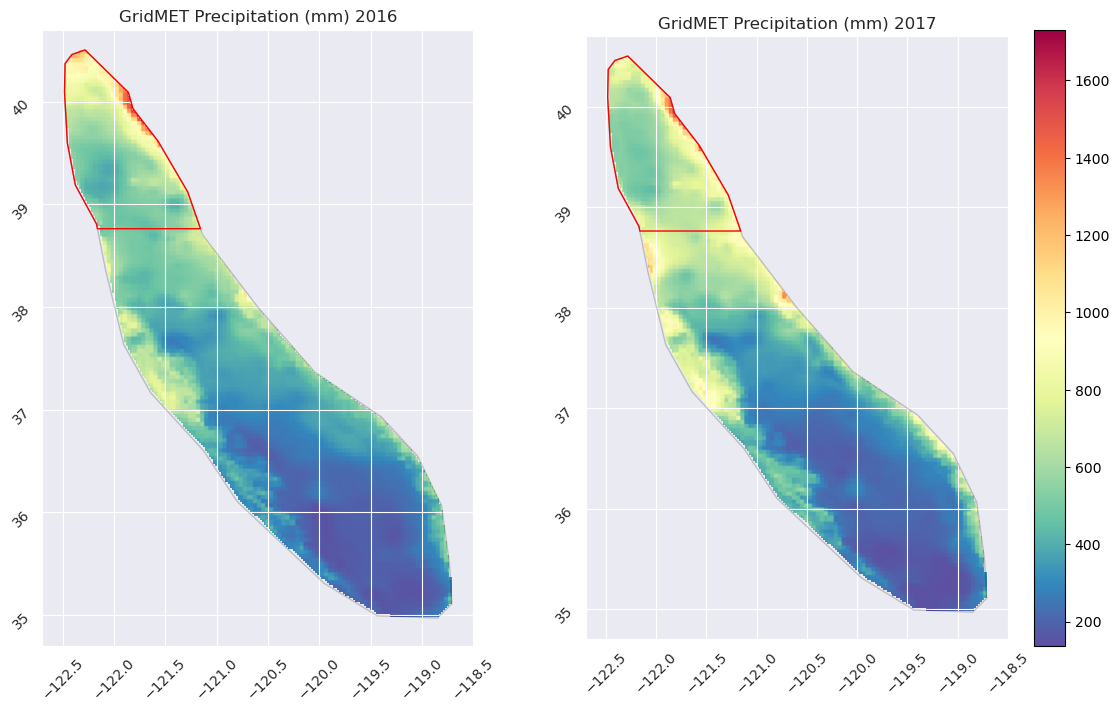

In [44]:
precip_2016_data = '../../Data_main/Data_Drivers_of_ET/scratch/GridMET_Precip_2016_CV.tif'
precip_2017_data = '../../Data_main/Data_Drivers_of_ET/scratch/GridMET_Precip_2017_CV.tif'

central_valley = '../../Data_main/Data_Drivers_of_ET/ROIs/CV.shp'
roi_30m = '../../Data_main/Data_Drivers_of_ET/ROIs/For_30m/ROI_CA_30m.shp'

precip_2016 = rio.open(precip_2016_data)
precip_2017 = rio.open(precip_2017_data)
CV_gdf = gpd.read_file(central_valley)
roi_30m_gdf = gpd.read_file(roi_30m)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 8),  gridspec_kw={'width_ratios': [1, 1.15]})
plt.style.use('default')

CV_gdf.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[0])
roi_30m_gdf.plot(facecolor='none', edgecolor='red', alpha=1, ax=ax[0])
show(precip_2016, ax=ax[0], cmap='Spectral_r')
ax[0].set_xlim(-122.7, -118.5)
ax[0].set_ylim(34.7, 40.7)
ax[0].tick_params(axis='both', rotation=45)
ax[0].set_title('GridMET Precipitation (mm) 2016')

CV_gdf.plot(facecolor='none', edgecolor='black', alpha=0.2, ax=ax[1])
roi_30m_gdf.plot(facecolor='none', edgecolor='red', alpha=1, ax=ax[1])
show(precip_2017, ax=ax[1], cmap='Spectral_r')
ax[1].set_xlim(-122.7, -118.5)
ax[1].set_ylim(34.7, 40.7)
ax[1].tick_params(axis='both', rotation=45)
ax[1].set_title('GridMET Precipitation (mm) 2017')

plt.colorbar(ax[1].get_images()[0])